<a href="https://colab.research.google.com/github/Orlane03/chatbot_langchain/blob/main/RDFlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdflib

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.9 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
!pip install rdflib networkx scikit-learn matplotlib


In [ ]:
from rdflib import URIRef, BNode, Literal
from rdflib import Namespace
from rdflib.namespace import CSVW, DC, DCAT, DCTERMS, DOAP, FOAF, ODRL2, ORG, OWL
from rdflib import Graph, URIRef, Literal, BNode
from rdflib.namespace import FOAF, RDF

In [ ]:
from rdflib import Graph, RDF, URIRef, Namespace

# Load the RDF data
graph = Graph()

graph.parse("/content/drive/MyDrive/TPE_Master_1/teaching_akg (2).ttl", format="ttl")

# Define namespace and type for entities (adjust as needed)
TAO = Namespace("http://sonfack.com/2024/01/tao#")  # Replace with your actual namespace

# Extract and print relevant assertions
relevant_assertions = []

for subj, pred, obj in graph:
    # Exclude subjects and predicates starting with "has" or "is"
    if not str(pred).startswith("http://sonfack.com/2024/01/tao#has") and not str(pred).startswith("http://sonfack.com/2024/01/tao#is"):
        relevant_assertions.append((subj, pred, obj))

# Print relevant assertions
for subj, pred, obj in relevant_assertions:
    print(f"Subject: {subj.split('#')[-1]}\nPredicate: {pred.split('#')[-1]}\nObject: {obj.split('#')[-1]}\n" )



Subject: http://sonfack.com/2023/12/tao/isFollowedBy
Predicate: comment
Object: An activity is followed by another activity

Subject: http://sonfack.com/2023/12/tao/isResponsibleFor
Predicate: range
Object: http://sonfack.com/2023/12/cao/Activity

Subject: http://sonfack.com/2023/12/tao/TeachingMaterial
Predicate: type
Object: Class

Subject: http://sonfack.com/2023/12/tao/dbtutorial-78aca3f8-53fd-4f47-9406-414b493efe19
Predicate: http://sonfack.com/2023/12/cao/hasBeginTime
Object: http://sonfack.com/2023/12/tao/10AM-f5ee7bc0-fb61-4d4e-9a32-565a5a7df03a

Subject: http://sonfack.com/2023/12/tao/uicourse-eaf2d283-4eb8-4024-a2c5-539984984fdd
Predicate: http://sonfack.com/2023/12/cao/isComposedOf
Object: http://sonfack.com/2023/12/tao/lecturing-5923c0c5-fe15-4cf9-8dc1-e3f5e73ba02a

Subject: http://sonfack.com/2023/12/tao/projectObject
Predicate: subClassOf
Object: http://sonfack.com/2023/12/cao/Object

Subject: http://sonfack.com/2023/12/tao/Teacher
Predicate: subClassOf
Object: http://son

In [ ]:
from rdflib import Namespace, Graph, URIRef
from rdflib.namespace import RDF
import networkx as nx
import matplotlib.pyplot as plt

akg_file = "/content/drive/MyDrive/TPE_Master_1/teaching_akg (2).ttl"
g = Graph()
g.parse(akg_file)
G = nx.DiGraph()
akg_namespace = Namespace("http://sonfack.com/2023/12/tao/")
cao_namespace = Namespace("http://sonfack.com/2023/12/cao/")


def read_all_activities(akg: Graph, as_str=True) -> list:
    """This function returns all activities of an activity knowledge graph
    - akg: an activity knowledge graph as parsed by RDFLib
    - as_str: (boolean) tells if the activities are simple str default = True
    """
    activities_list = [str(activity) if as_str else activity for activity in akg.subjects(predicate=RDF.type, object=cao_namespace.Activity, unique=True)]
    return activities_list


def read_akg_node(node_uri: str, akg:Graph, as_str=True) -> dict:
    """This function returns all elements directly linked to a akg node
    - activity_uri (string): the given activity uri in graph akg
    - akg (Graph): an activity knowledge graph as parsed by RDFLib
    """
    activity_info = {}
    activity_uri_ref = f"{akg_namespace}{node_uri}"
    print(activity_uri_ref)
    for act_predicate, act_object in akg.predicate_objects(subject=URIRef(activity_uri_ref)):
        pred = act_predicate
        obj = act_object
        if as_str:
            pred = str(act_predicate)
            obj = str(act_object)
        if pred in activity_info:
            existing_objects = activity_info[pred] + [obj]
            activity_info[pred] = existing_objects
        else:
            activity_info[pred] = [obj]
    return activity_info


In [ ]:
def add_activity_to_nxgraph(G, activity_uri, activity_info):
    #print("ajout de l'activité", activity_uri)
    #print("affichage des informations", activity_info)
    activity_g = nx.DiGraph()

    for pred, obj_list in activity_info.items():
        pred_label = pred.split('/')[-1]
        if '#' in pred_label:
            pred_label = pred_label.split('#')[1]

        for obj in obj_list:
            obj_label = obj.split('/')[-1]
            node_info = read_akg_node(obj_label, g)

            if node_info:
                # Assurez-vous que vous récupérez une chaîne et non une liste
                obj_label = node_info.get('http://sonfack.com/2023/12/tao/hasName', [None])[0]
                if obj_label is None:
                    continue  # Passer à l'itération suivante si obj_label est None


            G.add_node(activity_uri)
            G.add_node(obj_label)
            G.add_edge(activity_uri, obj_label, label=pred_label)
            activity_g.add_node(activity_uri)
            activity_g.add_node(obj_label)
            activity_g.add_edge(activity_uri, obj_label, label=pred_label)

    visualize_activity(activity_g)


In [ ]:
def visualize_activity(G):
  # Visualize the graph
  plt.figure(figsize=(12, 12))

  # Generate positions for nodes using a layout algorithm
  pos = nx.spring_layout(G, seed=42)

  # Draw the nodes and edges
  nx.draw(G, pos, with_labels=True, node_size=300, node_color="blue", font_size=5, font_weight="bold", edge_color="black")

  # Draw edge labels
  edge_labels = nx.get_edge_attributes(G, 'label')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

  # Show plot
  plt.title("Graphe de Connaissances des Activités")
  plt.show()


['http://sonfack.com/2023/12/tao/dbcourse-b63a9944-19f6-4f41-bcbd-9333ede86272', 'http://sonfack.com/2023/12/tao/dbtutorial-78aca3f8-53fd-4f47-9406-414b493efe19', 'http://sonfack.com/2023/12/tao/pycourse-3f993bf5-1c2f-4f58-b85a-7b6b92bcf64b', 'http://sonfack.com/2023/12/tao/pypractical-f18f0361-3f12-4b3d-9459-ce2a019b4668', 'http://sonfack.com/2023/12/tao/uicourse-eaf2d283-4eb8-4024-a2c5-539984984fdd', 'http://sonfack.com/2023/12/tao/pmcourse-adee0f07-9e90-412b-95d4-b45d7a7476bb', 'http://sonfack.com/2023/12/tao/secourse-511f491d-ea2b-428f-900e-604ea778dab5', 'http://sonfack.com/2023/12/tao/setutorial-adbef907-11e0-40c1-8dd2-37eb02899ea9', 'http://sonfack.com/2023/12/tao/sepractical-88ca540f-fd64-4a3c-92fd-590a12f1f46b', 'http://sonfack.com/2023/12/tao/seproject-d3e90a3c-f550-45eb-b00e-59a3c6120318']
http://sonfack.com/2023/12/tao/dbcourse-b63a9944-19f6-4f41-bcbd-9333ede86272
{'http://www.w3.org/1999/02/22-rdf-syntax-ns#type': ['http://sonfack.com/2023/12/cao/Activity'], 'http://sonfac

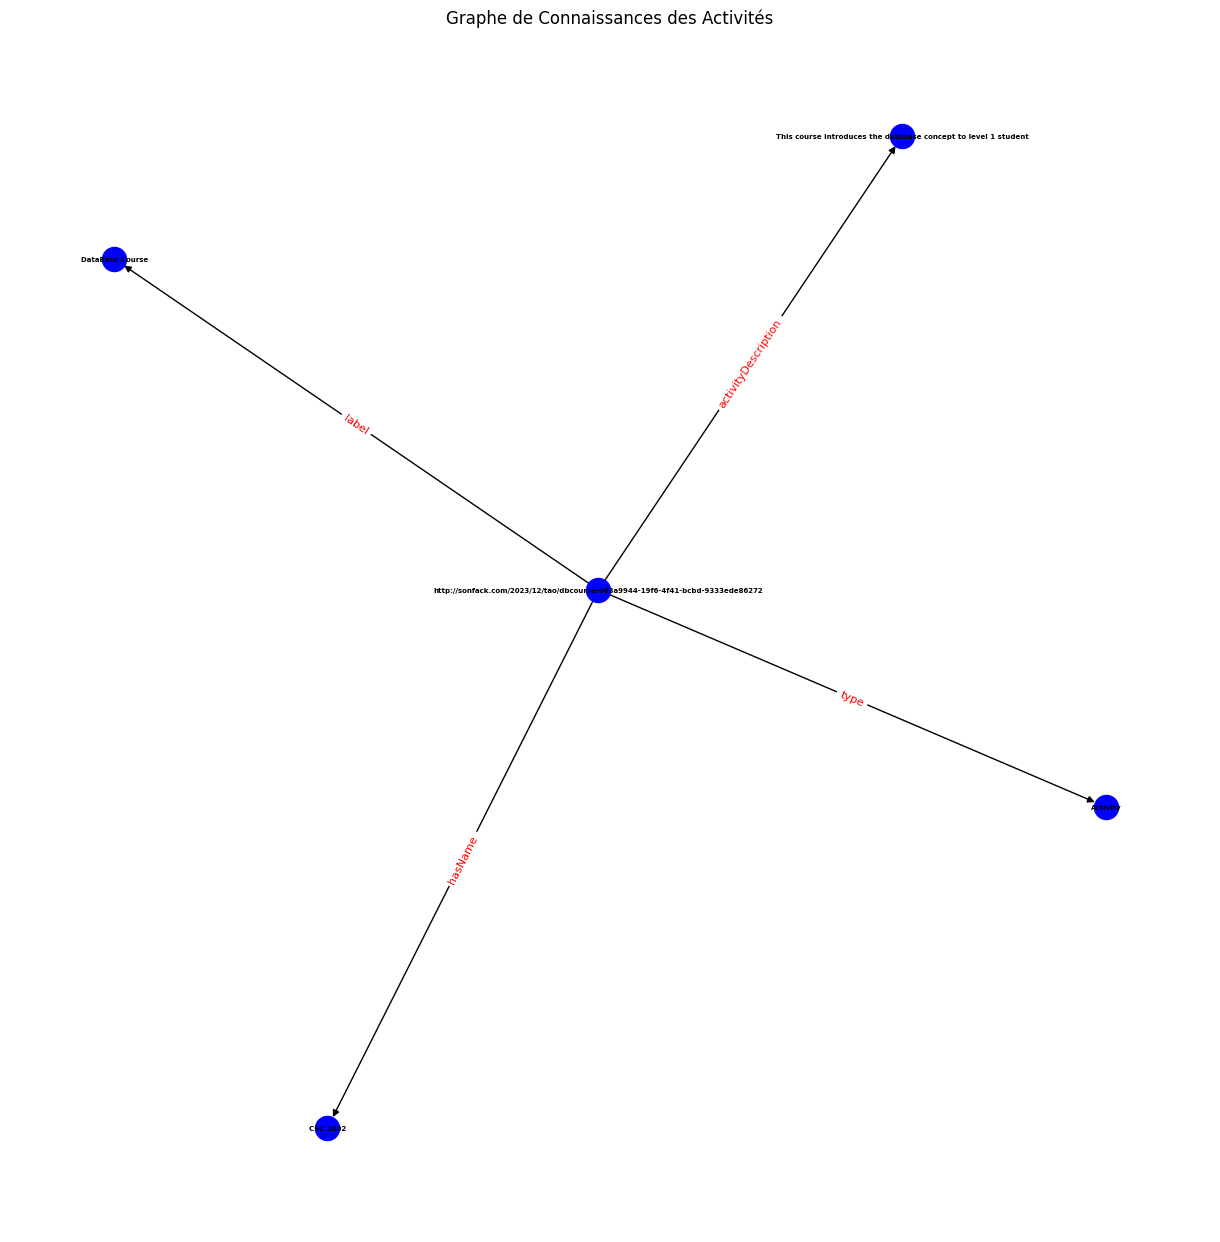

http://sonfack.com/2023/12/tao/dbtutorial-78aca3f8-53fd-4f47-9406-414b493efe19
{'http://www.w3.org/1999/02/22-rdf-syntax-ns#type': ['http://sonfack.com/2023/12/cao/Activity'], 'http://sonfack.com/2023/12/cao/hasName': ['CSC 1022'], 'http://www.w3.org/2000/01/rdf-schema#label': ['DataBase Tutorial'], 'http://sonfack.com/2023/12/cao/hasBeginTime': ['http://sonfack.com/2023/12/tao/10AM-f5ee7bc0-fb61-4d4e-9a32-565a5a7df03a'], 'http://sonfack.com/2023/12/cao/activityDescription': ['This tutorial answers database question to level 1 student'], 'http://sonfack.com/2023/12/cao/hasDuration': ['120'], 'http://sonfack.com/2023/12/cao/hasObjective': ['http://sonfack.com/2023/12/tao/objective-59c2099d-746e-4872-bbc1-ea0891430f47'], 'http://sonfack.com/2023/12/tao/hasLocation': ['http://sonfack.com/2023/12/tao/computerroom-4ecbe47c-8f8e-4835-93ac-16d2392e30a2', 'http://sonfack.com/2023/12/tao/classroom-c1a5b39b-992c-49fb-9c7e-a1ffaa92e884'], 'http://sonfack.com/2023/12/cao/isComposedOf': ['http://so

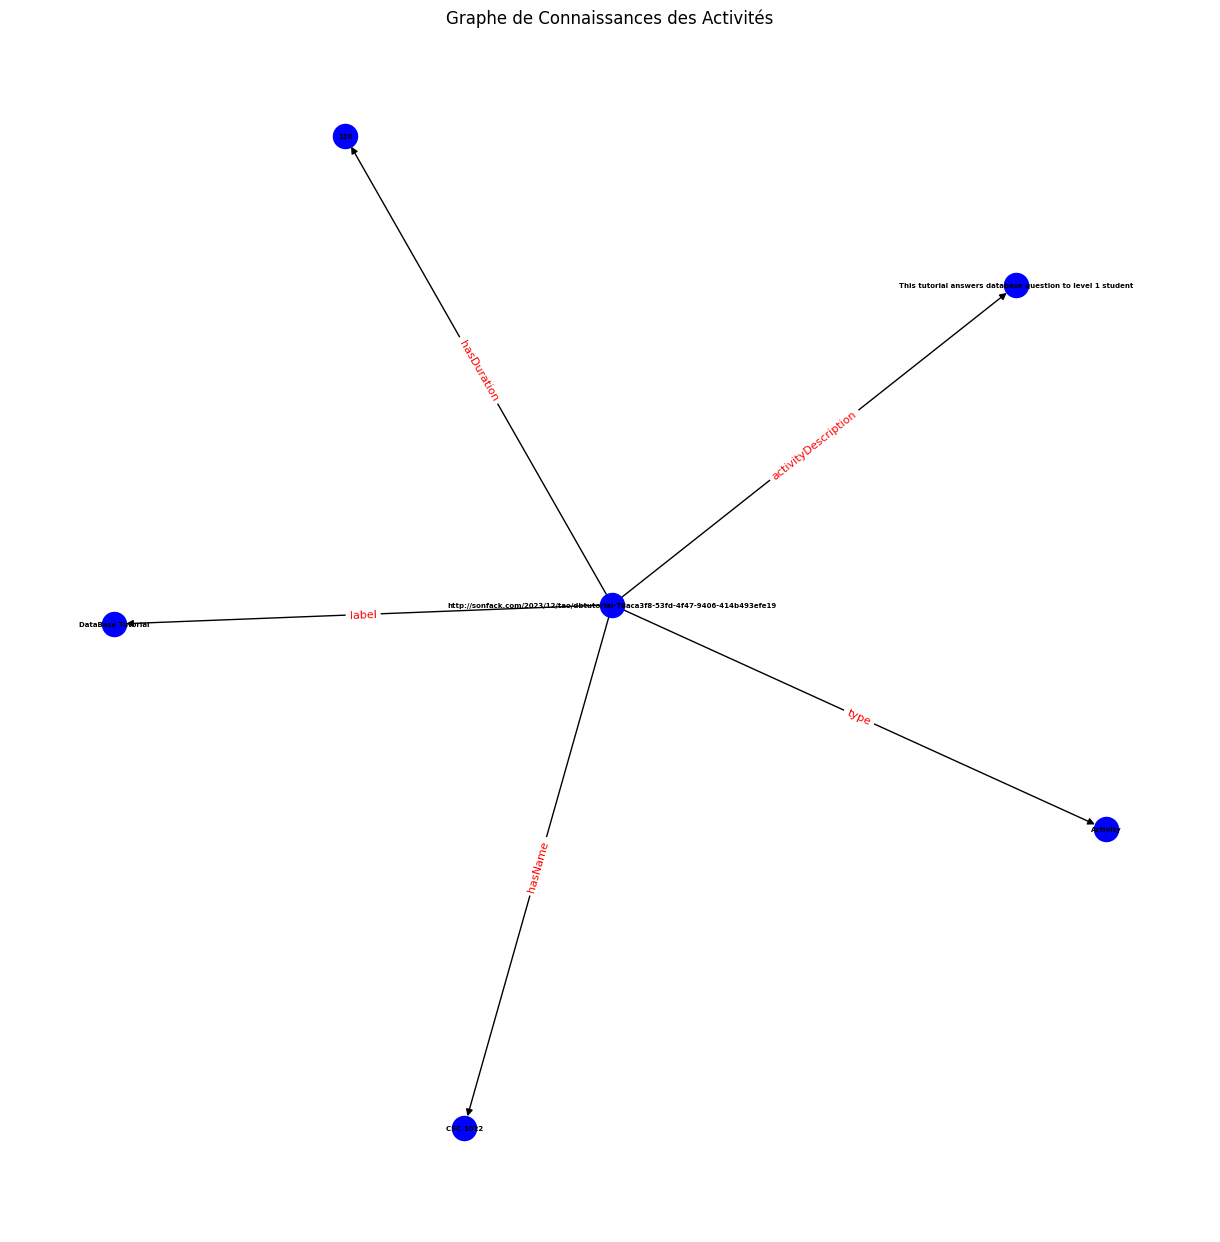

http://sonfack.com/2023/12/tao/pycourse-3f993bf5-1c2f-4f58-b85a-7b6b92bcf64b
{'http://www.w3.org/1999/02/22-rdf-syntax-ns#type': ['http://sonfack.com/2023/12/cao/Activity'], 'http://sonfack.com/2023/12/cao/hasName': ['CSC 1001'], 'http://www.w3.org/2000/01/rdf-schema#label': ['Python Course'], 'http://sonfack.com/2023/12/cao/activityDescription': ['This course introduces the python programming to level 1 student'], 'http://sonfack.com/2023/12/cao/hasTime': ['http://sonfack.com/2023/12/tao/8AM-10AM-0ea7a574-e6be-4dc7-abe1-85a6b8ce2e3d'], 'http://sonfack.com/2023/12/cao/hasObjective': ['http://sonfack.com/2023/12/tao/objective-969f073e-1e01-4ad0-a0f0-fb806ba5a50e'], 'http://sonfack.com/2023/12/cao/hasLocation': ['http://sonfack.com/2023/12/tao/computerroom-5a2454c8-c664-401c-86b7-425e75dddc39', 'http://sonfack.com/2023/12/tao/tutorialroom-351e99f6-c93b-4377-b987-511652d2eefe'], 'http://sonfack.com/2023/12/tao/isFollowedBy': ['http://sonfack.com/2023/12/tao/pypractical-f18f0361-3f12-4b3d-

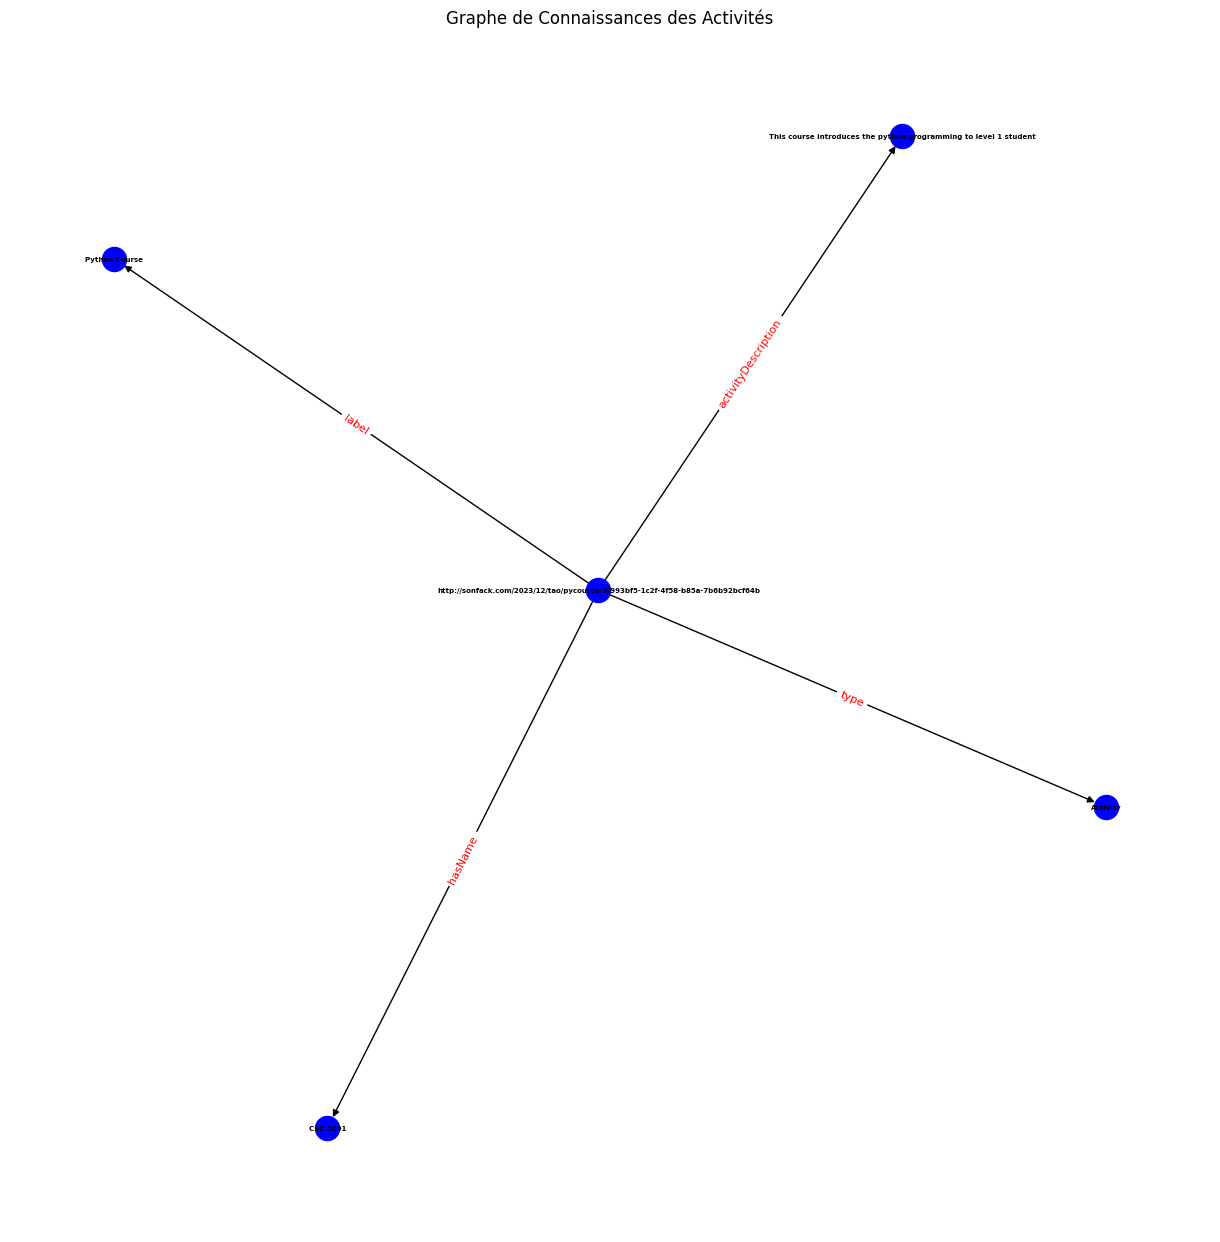

http://sonfack.com/2023/12/tao/pypractical-f18f0361-3f12-4b3d-9459-ce2a019b4668
{'http://www.w3.org/1999/02/22-rdf-syntax-ns#type': ['http://sonfack.com/2023/12/cao/Activity'], 'http://sonfack.com/2023/12/cao/hasName': ['CSC 1011'], 'http://www.w3.org/2000/01/rdf-schema#label': ['Python Practical'], 'http://sonfack.com/2023/12/cao/activityDescription': ['This course is for monitoring python programming practicals for level 1 student'], 'http://sonfack.com/2023/12/cao/hasRule': ['http://sonfack.com/2023/12/tao/rule-cdc19603-45e5-4c06-8d5a-47624147f67e'], 'http://sonfack.com/2023/12/cao/hasTime': ['http://sonfack.com/2023/12/tao/8AM-10AM-1470781d-1128-4f43-ab61-4088953f071a'], 'http://sonfack.com/2023/12/cao/hasObjective': ['http://sonfack.com/2023/12/tao/objective-969f073e-1e01-4ad0-a0f0-fb806ba5a50e'], 'http://sonfack.com/2023/12/cao/hasLocation': ['http://sonfack.com/2023/12/tao/computerroom-5a2454c8-c664-401c-86b7-425e75dddc39', 'http://sonfack.com/2023/12/tao/tutorialroom-351e99f6-c

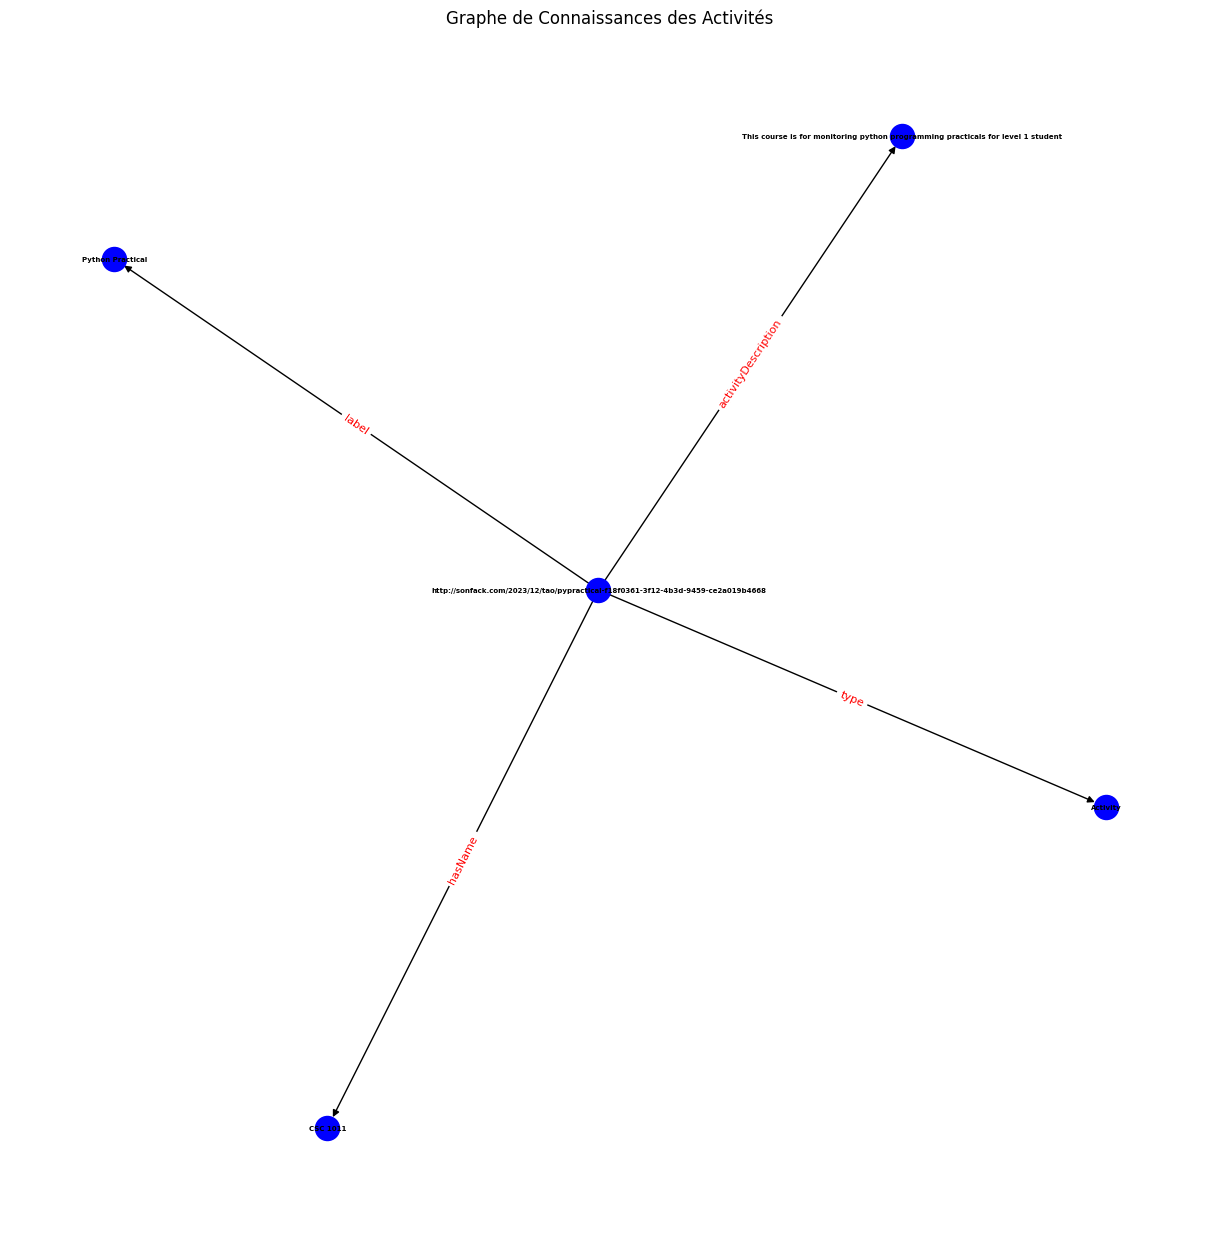

http://sonfack.com/2023/12/tao/uicourse-eaf2d283-4eb8-4024-a2c5-539984984fdd
{'http://www.w3.org/1999/02/22-rdf-syntax-ns#type': ['http://sonfack.com/2023/12/cao/Activity'], 'http://sonfack.com/2023/12/cao/hasName': ['CSC 1006'], 'http://www.w3.org/2000/01/rdf-schema#label': ['UserInterface Course'], 'http://sonfack.com/2023/12/cao/activityDescription': ['This course introduces the user interface design principles to level 1 student'], 'http://sonfack.com/2023/12/cao/hasTime': ['http://sonfack.com/2023/12/tao/10AM-12AM-6ab82d7d-72dc-40f2-a209-8bc6b4bb04e7'], 'http://sonfack.com/2023/12/cao/hasObjectiveive': ['http://sonfack.com/2023/12/tao/objective-9a59e20a-60f0-4798-8895-50f6b79621c5'], 'http://sonfack.com/2023/12/cao/hasLocation': ['http://sonfack.com/2023/12/tao/computerroom-9cd6c49c-e52f-48ef-9d23-d868af4802c4', 'http://sonfack.com/2023/12/tao/classroom-9b1749fc-8ce7-42ce-89d6-4e7ff8b826c7'], 'http://sonfack.com/2023/12/cao/isComposedOf': ['http://sonfack.com/2023/12/tao/lecturing

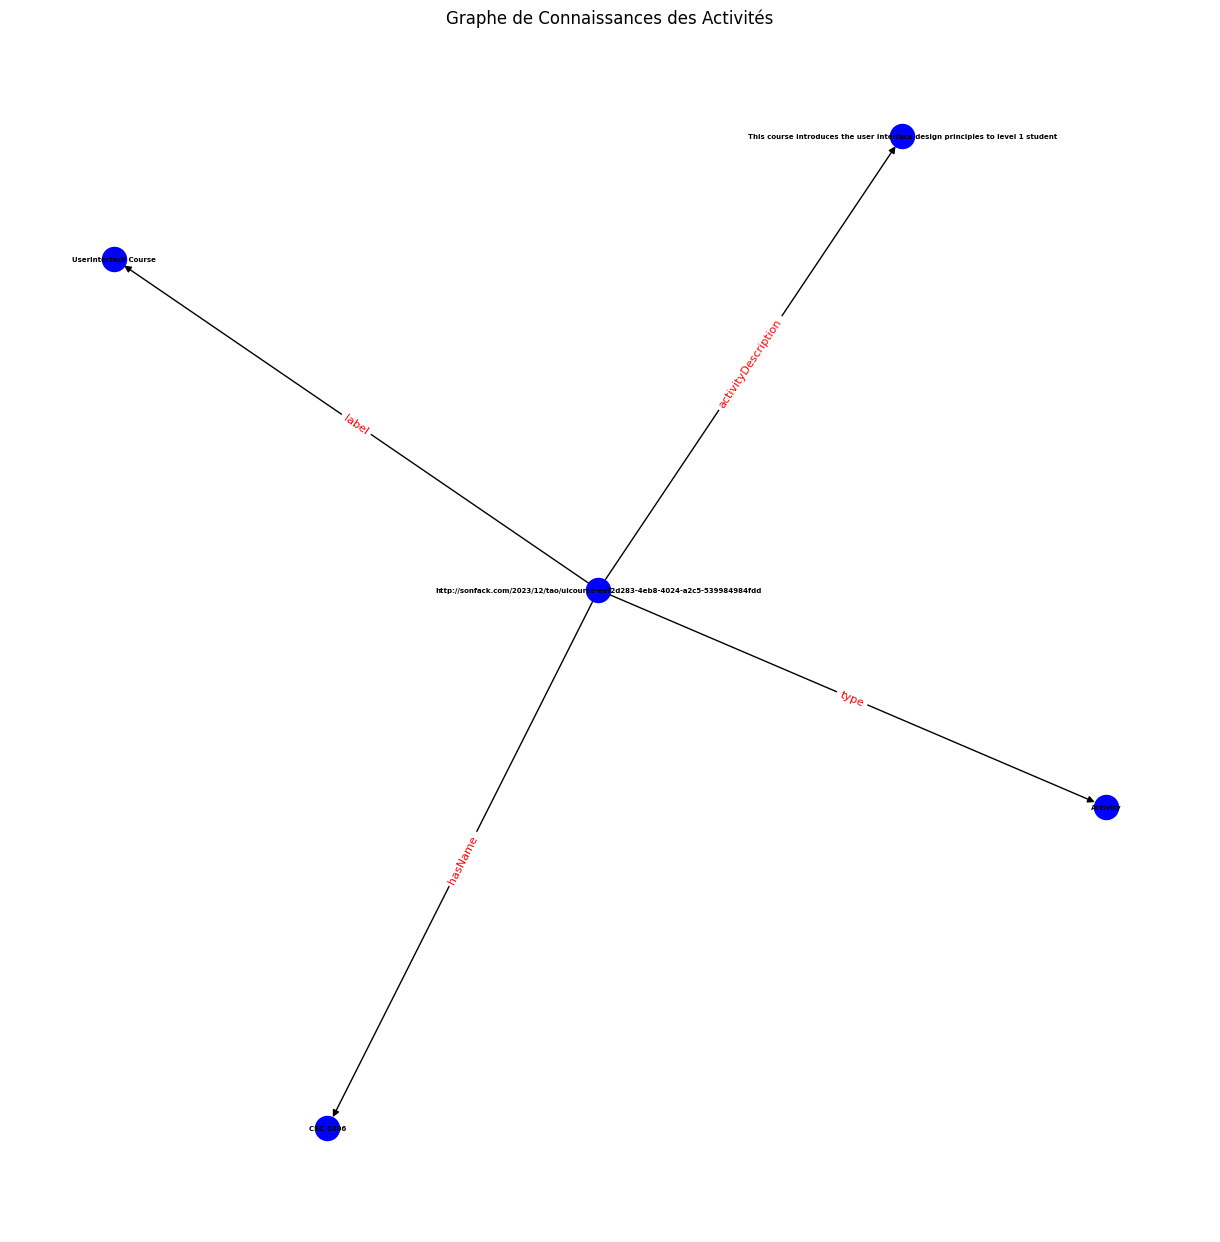

http://sonfack.com/2023/12/tao/pmcourse-adee0f07-9e90-412b-95d4-b45d7a7476bb
{'http://www.w3.org/1999/02/22-rdf-syntax-ns#type': ['http://sonfack.com/2023/12/cao/Activity'], 'http://sonfack.com/2023/12/cao/hasName': ['ProjectManagement Course'], 'http://sonfack.com/2023/12/cao/activityDescription': ['This course introduces project management concepts to level 1 student'], 'http://sonfack.com/2023/12/cao/hasTime': ['http://sonfack.com/2023/12/tao/8AM-10AM-b139b467-7fbf-4298-9338-fa372b608e5e'], 'http://sonfack.com/2023/12/cao/hasObjective': ['http://sonfack.com/2023/12/tao/objective-0b6e8fa9-d03d-4636-ab9c-b34578b4ea45'], 'http://sonfack.com/2023/12/cao/hasLocation': ['http://sonfack.com/2023/12/tao/classroom-3414ff41-3e7a-44de-a679-baac1ab873c2'], 'http://sonfack.com/2023/12/cao/isComposedOf': ['http://sonfack.com/2023/12/tao/lecturing-12b5c207-f470-4bf3-bb3d-e6b31c954954'], 'http://sonfack.com/2023/12/cao/isCarriedOutWith': ['http://sonfack.com/2023/12/tao/book-5afdf1f7-b15f-450b-be5f

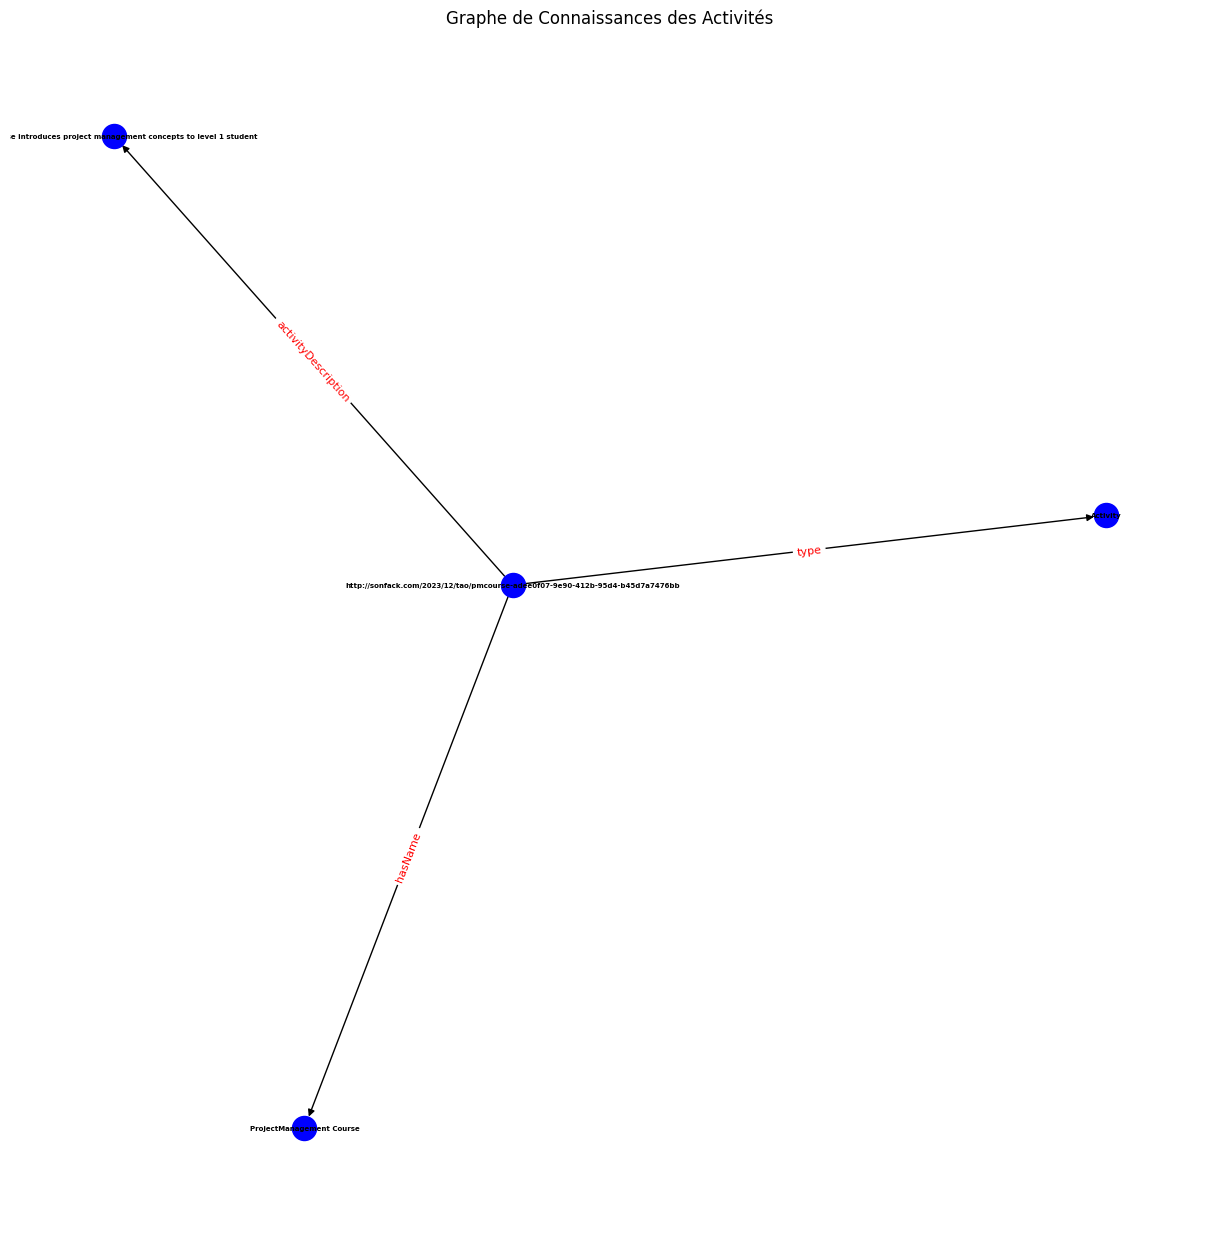

http://sonfack.com/2023/12/tao/secourse-511f491d-ea2b-428f-900e-604ea778dab5
{'http://www.w3.org/1999/02/22-rdf-syntax-ns#type': ['http://sonfack.com/2023/12/cao/Activity'], 'http://sonfack.com/2023/12/cao/hasName': ['CSC 1003'], 'http://www.w3.org/2000/01/rdf-schema#label': ['Software Engineering Course'], 'http://sonfack.com/2023/12/cao/activityDescription': ['This course introduces software engineering to level 1 student'], 'http://sonfack.com/2023/12/cao/hasDuration': ['120'], 'http://sonfack.com/2023/12/cao/hasEndTime': ['http://sonfack.com/2023/12/tao/12AM-6ec5a9a1-54b9-4310-96f4-9ecbdbf8344f'], 'http://sonfack.com/2023/12/cao/hasObjective': ['http://sonfack.com/2023/12/tao/objective-f4de69e1-e2ba-41a6-a268-803293e73080'], 'http://sonfack.com/2023/12/cao/hasLocation': ['http://sonfack.com/2023/12/tao/classroom-25eafa60-5f87-4e1f-9609-93bcdcfbb0c9'], 'http://sonfack.com/2023/12/tao/isFollowedBy': ['http://sonfack.com/2023/12/tao/setutorial-adbef907-11e0-40c1-8dd2-37eb02899ea9'], '

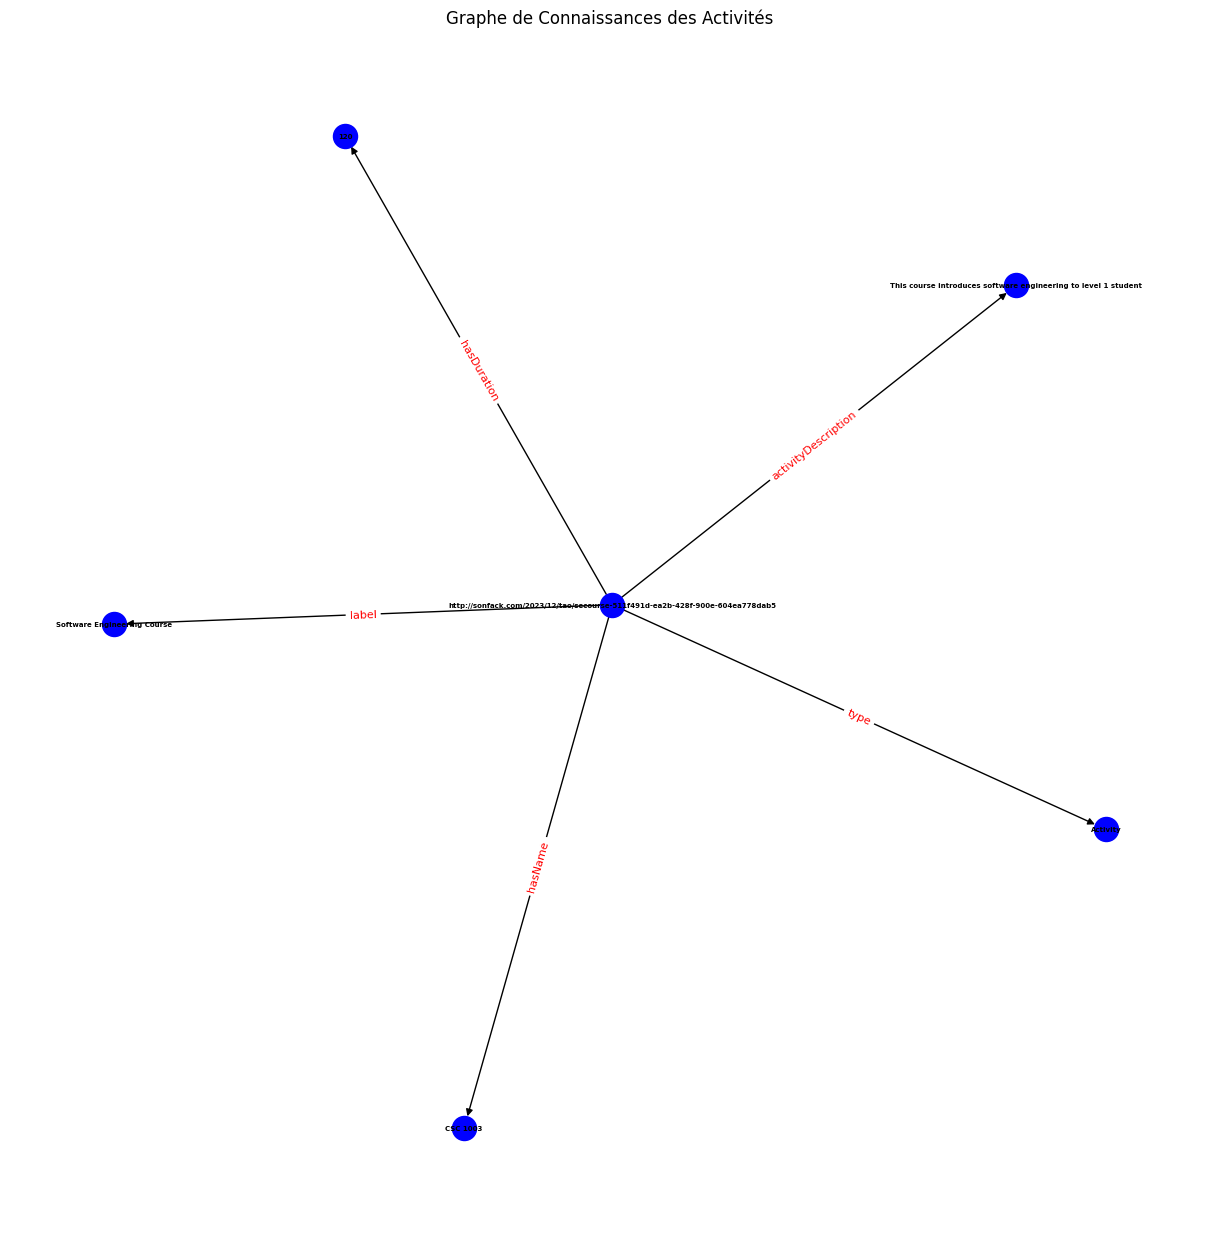

http://sonfack.com/2023/12/tao/setutorial-adbef907-11e0-40c1-8dd2-37eb02899ea9
{'http://www.w3.org/1999/02/22-rdf-syntax-ns#type': ['http://sonfack.com/2023/12/cao/Activity'], 'http://sonfack.com/2023/12/cao/hasName': ['CSC 1023'], 'http://www.w3.org/2000/01/rdf-schema#label': ['Software Engineering Tutorial'], 'http://sonfack.com/2023/12/cao/activityDescription': ['This tutorial answers level 1 student questions on software engineering'], 'http://sonfack.com/2023/12/cao/hasBeginTime': ['http://sonfack.com/2023/12/tao/10AM-0fbdca75-5c06-4a88-9181-ee1a035a7fec'], 'http://sonfack.com/2023/12/cao/hasDuration': ['120'], 'http://sonfack.com/2023/12/cao/hasObjective': ['http://sonfack.com/2023/12/tao/objective-f4de69e1-e2ba-41a6-a268-803293e73080'], 'http://sonfack.com/2023/12/cao/hasLocation': ['http://sonfack.com/2023/12/tao/tutorialroom-351e99f6-c93b-4377-b987-511652d2eefe'], 'http://sonfack.com/2023/12/tao/isFollowedBy': ['http://sonfack.com/2023/12/tao/sepractical-88ca540f-fd64-4a3c-92f

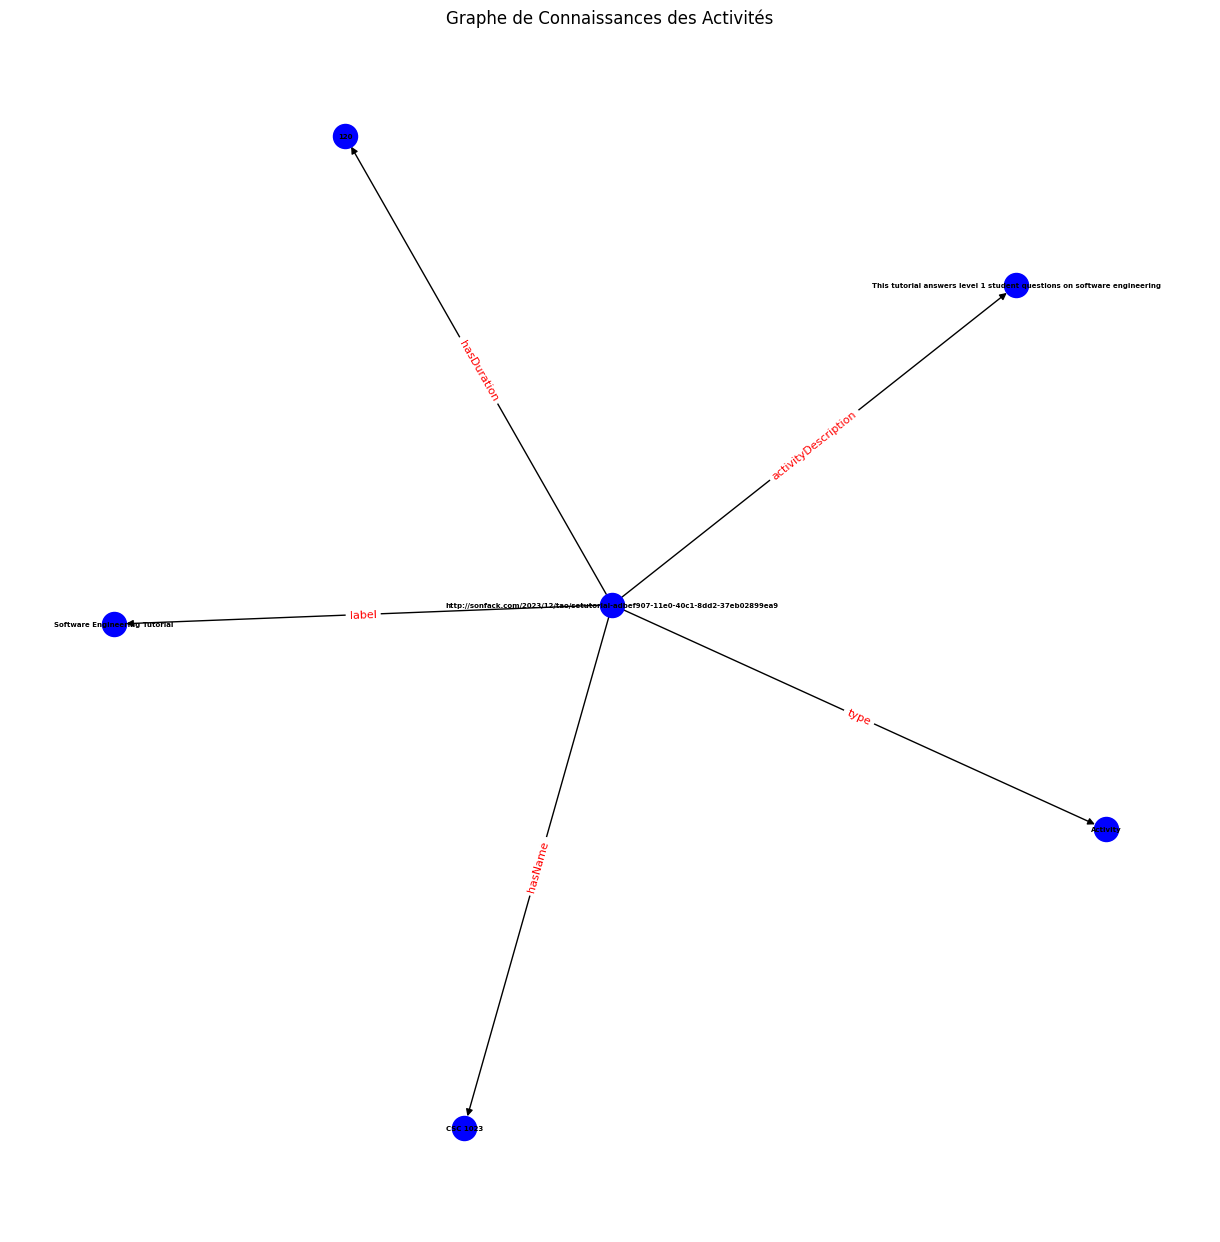

http://sonfack.com/2023/12/tao/sepractical-88ca540f-fd64-4a3c-92fd-590a12f1f46b
{'http://www.w3.org/1999/02/22-rdf-syntax-ns#type': ['http://sonfack.com/2023/12/cao/Activity'], 'http://sonfack.com/2023/12/cao/hasName': ['CSC 1013'], 'http://www.w3.org/2000/01/rdf-schema#label': ['Software Engineering Practical'], 'http://sonfack.com/2023/12/cao/activityDescription': ['This course monitor software engineering practical questions for level 1 student'], 'http://sonfack.com/2023/12/cao/hasRule': ['http://sonfack.com/2023/12/tao/rule-cdc19603-45e5-4c06-8d5a-47624147f67e'], 'http://sonfack.com/2023/12/cao/hasTime': ['http://sonfack.com/2023/12/tao/10AM-12AM-f4e589a5-aac9-42b7-b498-706732141ca1'], 'http://sonfack.com/2023/12/cao/hasObjective': ['http://sonfack.com/2023/12/tao/objective-f4de69e1-e2ba-41a6-a268-803293e73080'], 'http://sonfack.com/2023/12/cao/hasLocation': ['http://sonfack.com/2023/12/tao/computerroom-5a2454c8-c664-401c-86b7-425e75dddc39'], 'http://sonfack.com/2023/12/tao/isFoll

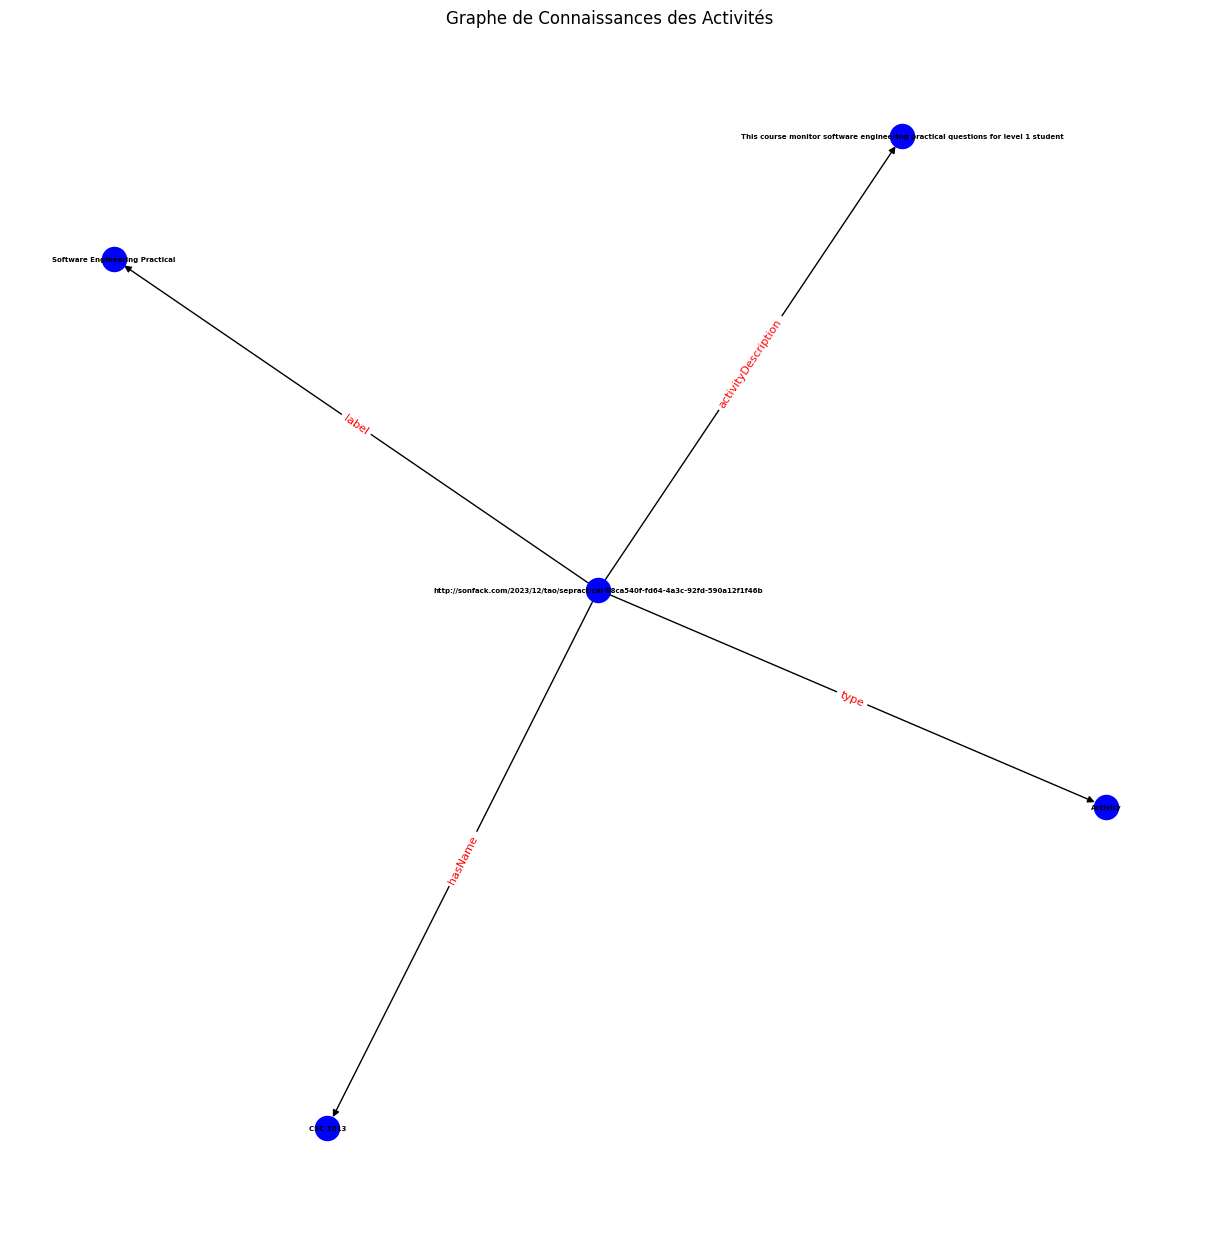

http://sonfack.com/2023/12/tao/seproject-d3e90a3c-f550-45eb-b00e-59a3c6120318
{'http://www.w3.org/1999/02/22-rdf-syntax-ns#type': ['http://sonfack.com/2023/12/cao/Activity'], 'http://www.w3.org/2000/01/rdf-schema#label': ['Software Engineering Project'], 'http://sonfack.com/2023/12/cao/activityDescription': ['This course is for follow up of software engineering projects of level 1 student'], 'http://sonfack.com/2023/12/cao/hasName': ['CSC 1005'], 'http://sonfack.com/2023/12/cao/hasTime': ['http://sonfack.com/2023/12/tao/08AM-10AM-35e7d9ed-4694-48e0-a6b6-394bd4155a13'], 'http://sonfack.com/2023/12/cao/hasObjective': ['http://sonfack.com/2023/12/tao/objective-284ef78c-99f5-45f0-935a-553678664616'], 'http://sonfack.com/2023/12/cao/hasLocation': ['http://sonfack.com/2023/12/tao/computerroom-5a2454c8-c664-401c-86b7-425e75dddc39'], 'http://sonfack.com/2023/12/cao/isBeneficialTo': ['http://sonfack.com/2023/12/tao/bsc-410688e8-e5d3-4e9c-9ca4-c28bf92827af'], 'http://sonfack.com/2023/12/cao/isCa

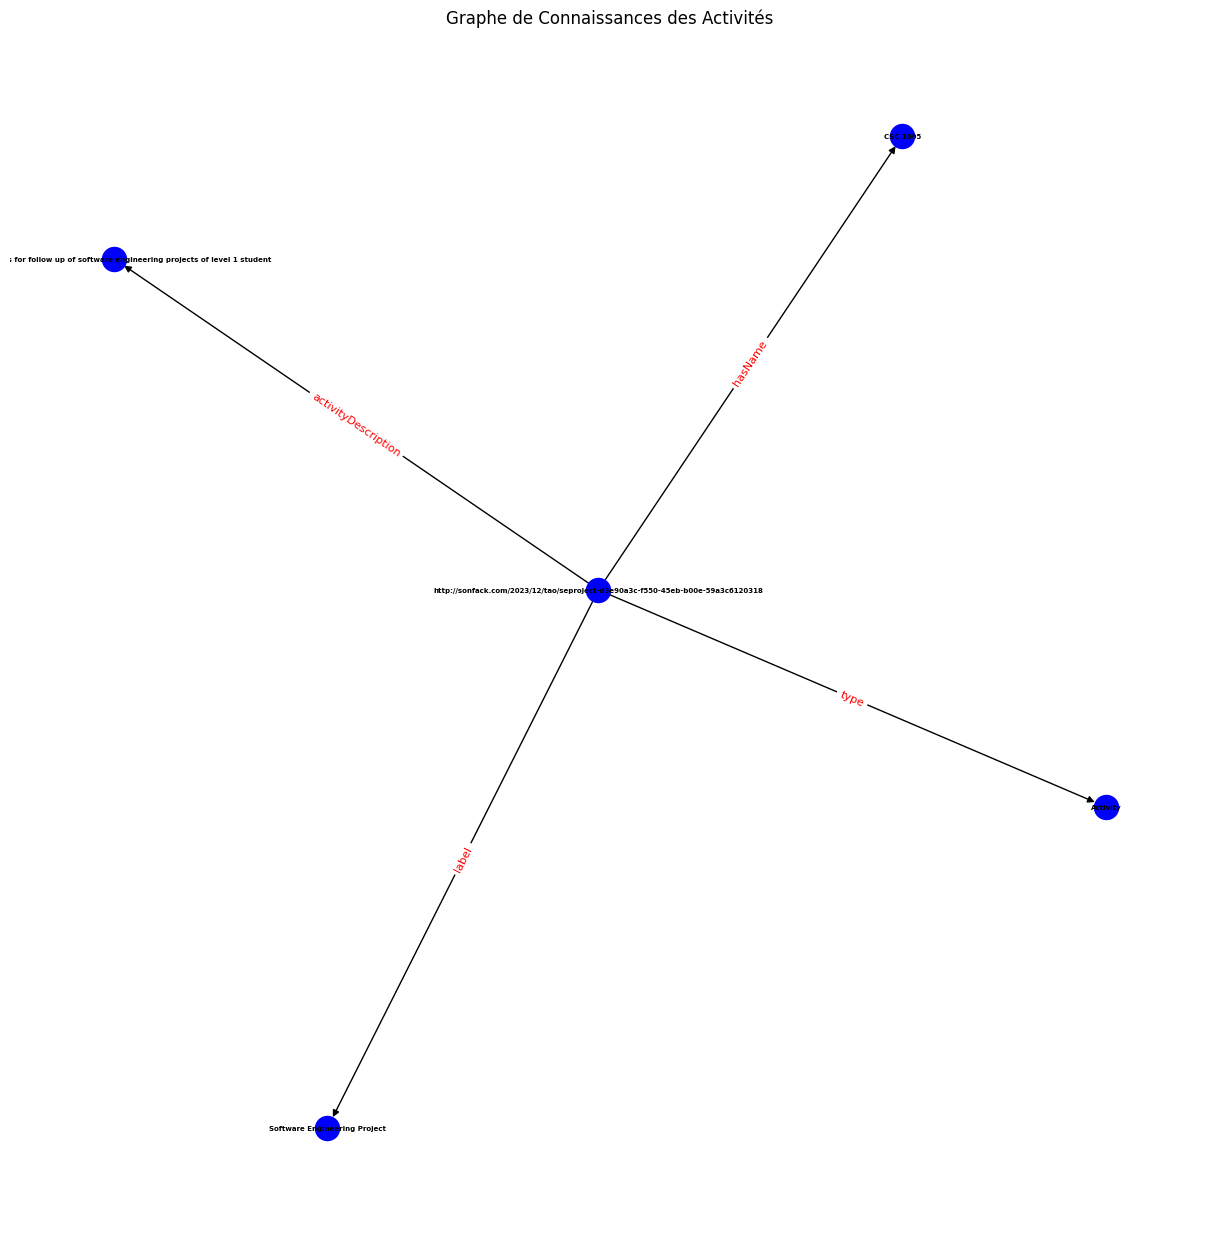

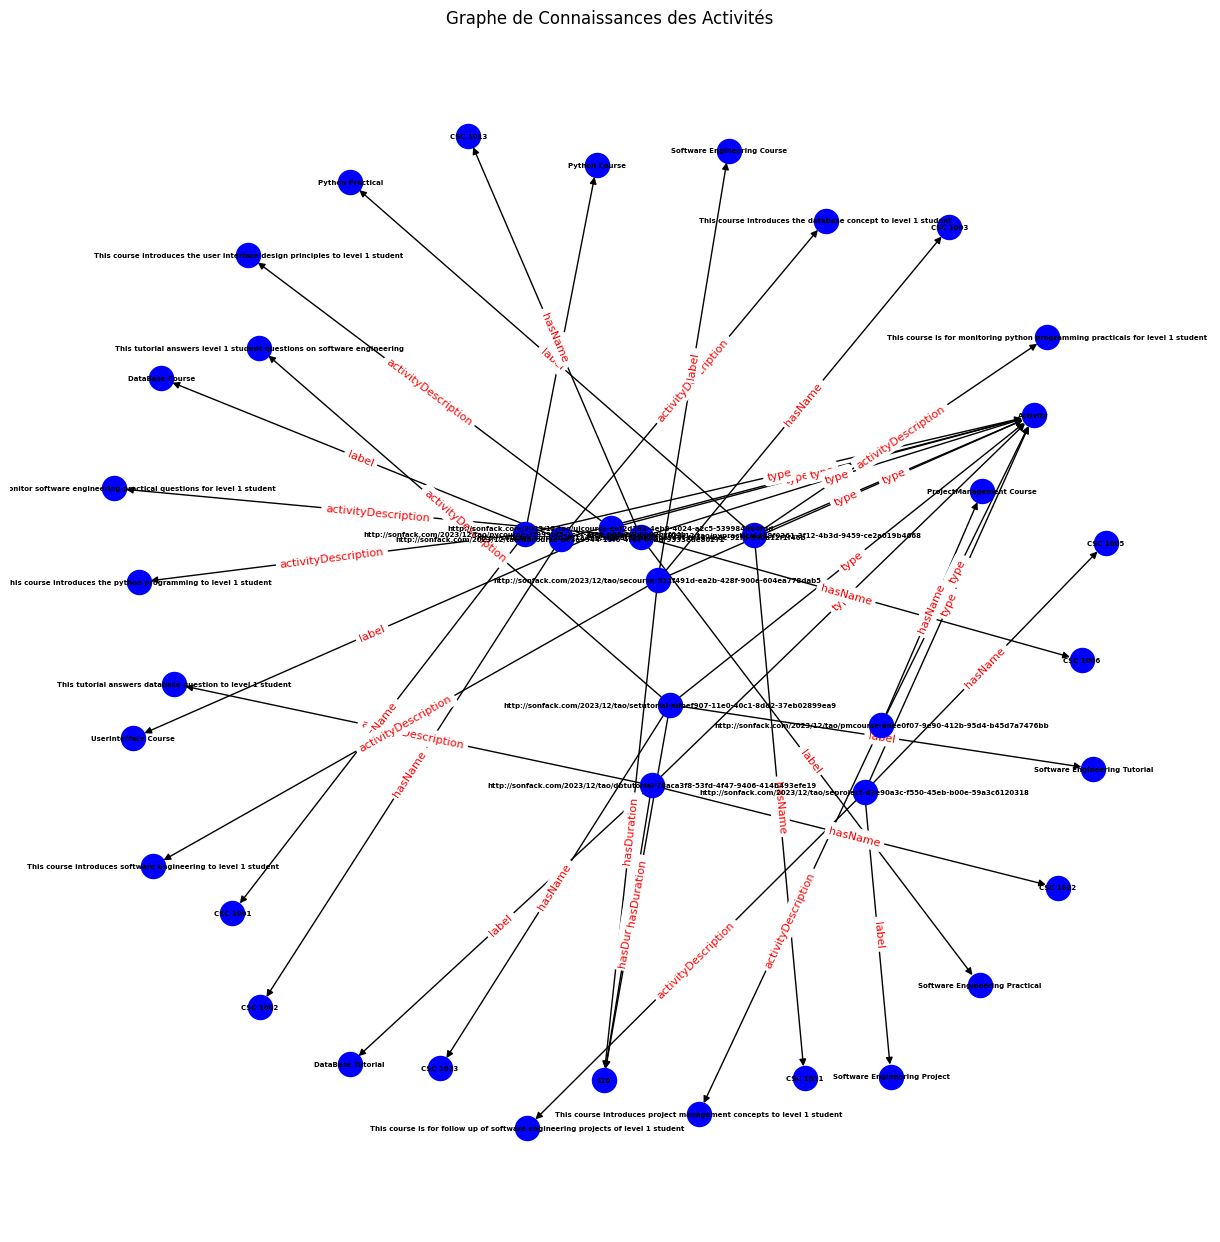

In [ ]:
liste_activity = read_all_activities(g, as_str=True)
print(liste_activity)
for activity in liste_activity:
  subj = activity.split('/')[-1]
  info_activity = read_akg_node(subj, g, as_str=True)
  print(info_activity)
  add_activity_to_nxgraph(G,activity,info_activity)


# Visualize the graph
plt.figure(figsize=(12, 12))

# Generate positions for nodes using a layout algorithm
pos = nx.spring_layout(G, seed=42)

# Draw the nodes and edges
nx.draw(G, pos, with_labels=True, node_size=300, node_color="blue", font_size=5, font_weight="bold", edge_color="black")

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

# Show plot
plt.title("Graphe de Connaissances des Activités")
plt.show()


In [ ]:
!pip install pyvis


  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 8.4 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [ ]:
from rdflib import Graph, Namespace, URIRef

# Charger le fichier RDF localement
g = Graph()

# Remplacer par le chemin de votre fichier TTL local
ttl_file_path = "/content/drive/MyDrive/TPE_Master_1/teaching_akg (2).ttl"

# Parser le fichier RDF au format Turtle
g.parse(ttl_file_path, format="ttl")

# ----- Définir les namespaces cao et tao -----
cao = Namespace("http://sonfack.com/2023/12/cao/")
tao = Namespace("http://sonfack.com/2023/12/tao/")

# ----- Requête SPARQL mise à jour pour regrouper les types de ressources -----
query_grouped_resources = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX cao: <http://sonfack.com/2023/12/cao/>
PREFIX tao: <http://sonfack.com/2023/12/tao/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>

SELECT DISTINCT ?resource ?resourceType
WHERE {
    ?resource rdf:type ?resourceType .

    # Exclure les ressources de type ontologique et autres propriétés non pertinentes
    FILTER NOT EXISTS { ?resource rdf:type owl:Ontology }
    FILTER NOT EXISTS { ?resource rdf:type owl:Class }
    FILTER NOT EXISTS { ?resource rdf:type owl:ObjectProperty }
    FILTER NOT EXISTS { ?resource rdf:type owl:TransitiveProperty }

    # Grouper les ressources par type de catégorie

    # Activités
    { ?resource rdf:type cao:Activity }
    UNION
    { ?resource rdf:type cao:Action }

    # Ressources matérielles
    UNION
    { ?resource rdf:type tao:Laptop }
    UNION
    { ?resource rdf:type tao:Desktop }
    UNION
    { ?resource rdf:type tao:HardDocument }
    UNION
    { ?resource rdf:type tao:Projector }

    # Ressources immatérielles
    UNION
    { ?resource rdf:type tao:DigitalResource }
    UNION
    { ?resource rdf:type tao:Video }
    UNION
    { ?resource rdf:type tao:SoftDocument }

    # Ressources humaines
    UNION
    { ?resource rdf:type tao:Teacher }
    UNION
    { ?resource rdf:type tao:Tutor }
    UNION
    { ?resource rdf:type tao:Students }

    # Ressources physiques
    UNION
    { ?resource rdf:type tao:ClassRoom }
    UNION
    { ?resource rdf:type tao:PracticalRoom }
    UNION
    { ?resource rdf:type tao:TutorialRoom }
}
"""

# Exécuter la requête SPARQL
results_grouped_resources = g.query(query_grouped_resources)

# Initialiser des listes distinctes pour chaque catégorie
activities = []
hard_resources = []
soft_resources = []
human_resources = []
physical_resources = []

# Organiser les ressources extraites dans les bonnes catégories
for row in results_grouped_resources:
    resource = row['resource']
    resource_type = row['resourceType']

    # Identifier et ajouter les ressources dans les bonnes listes
    if resource_type in [cao.Activity, cao.Action]:
        activities.append(resource)
    elif resource_type in [tao.Laptop, tao.Desktop, tao.HardDocument, tao.Projector]:
        hard_resources.append(resource)
    elif resource_type in [tao.DigitalResource, tao.Video, tao.SoftDocument]:
        soft_resources.append(resource)
    elif resource_type in [tao.Teacher, tao.Tutor, tao.Students]:
        human_resources.append(resource)
    elif resource_type in [tao.ClassRoom, tao.PracticalRoom, tao.TutorialRoom]:
        physical_resources.append(resource)

# Afficher les groupes de ressources extraits
print("Activités :")
for activity in activities:
    print(f"  - {activity}")

print("\nRessources matérielles :")
for hr in hard_resources:
    print(f"  - {hr}")

print("\nRessources immatérielles :")
for sr in soft_resources:
    print(f"  - {sr}")

print("\nRessources humaines :")
for hr in human_resources:
    print(f"  - {hr}")

print("\nRessources physiques :")
for pr in physical_resources:
    print(f"  - {pr}")


Activités :
  - http://sonfack.com/2023/12/tao/dbcourse-b63a9944-19f6-4f41-bcbd-9333ede86272
  - http://sonfack.com/2023/12/tao/dbtutorial-78aca3f8-53fd-4f47-9406-414b493efe19
  - http://sonfack.com/2023/12/tao/pycourse-3f993bf5-1c2f-4f58-b85a-7b6b92bcf64b
  - http://sonfack.com/2023/12/tao/pypractical-f18f0361-3f12-4b3d-9459-ce2a019b4668
  - http://sonfack.com/2023/12/tao/uicourse-eaf2d283-4eb8-4024-a2c5-539984984fdd
  - http://sonfack.com/2023/12/tao/pmcourse-adee0f07-9e90-412b-95d4-b45d7a7476bb
  - http://sonfack.com/2023/12/tao/secourse-511f491d-ea2b-428f-900e-604ea778dab5
  - http://sonfack.com/2023/12/tao/setutorial-adbef907-11e0-40c1-8dd2-37eb02899ea9
  - http://sonfack.com/2023/12/tao/sepractical-88ca540f-fd64-4a3c-92fd-590a12f1f46b
  - http://sonfack.com/2023/12/tao/seproject-d3e90a3c-f550-45eb-b00e-59a3c6120318
  - http://sonfack.com/2023/12/tao/lecturing-9246b9e2-d557-4869-885a-c541257280eb
  - http://sonfack.com/2023/12/tao/lecturing-5737c363-39a6-405a-87d1-9f15bee9e464
  -

In [ ]:
from pyvis.network import Network
from IPython.display import display, HTML
# Fonction pour organiser les ressources selon leurs types
def organize_resources_by_type(resources):
    resource_groups = {}

    for resource, resource_type in resources:
        if resource_type not in resource_groups:
            resource_groups[resource_type] = []
        resource_groups[resource_type].append(resource)

    return resource_groups

# Fonction pour créer le réseau PyVis avec la taille des nœuds variant selon le nombre de ressources dans chaque groupe
def visualize_resource_graph(resources):
    # Organiser les ressources par type
    resource_groups = organize_resources_by_type(resources)

    # Couleurs par type de ressource (modifiable selon les besoins)
    node_colors = {
        "Activités": "lightblue",
        "Ressources matérielles": "lightcoral",
        "Ressources immatérielles": "green",
        "Ressources humaines": "yellow",
        "Ressources physiques": "lightgray"
    }


# Créer le réseau PyVis
net = Network(notebook=True, cdn_resources='in_line')

# Ajouter les nœuds avec des tailles basées sur le nombre d'activités
for group_name, resources in resource_groups.items():
    node_size = len(resources) * 10  # Taille proportionnelle au nombre de ressources
    net.add_node(group_name, label=group_name, size=node_size, color=node_colors[group_name])

# Exemple de relations entre groupes (prédicats)
relations = [
    ("Activités", "Ressources matérielles", "requires"),
    ("Activités", "Ressources immatérielles", "utilizes"),
    ("Activités", "Ressources humaines", "involves"),
    ("Ressources matérielles", "Ressources physiques", "contains"),
    ("Ressources immatérielles", "Ressources humaines", "isUsedBy"),
    ("Ressources humaines", "Ressources physiques", "manages")
]

# Ajouter des arêtes avec des prédicats
for source, target, predicate in relations:
    net.add_edge(source, target, title=predicate, label=predicate)

# Désactiver la physique pour un agencement statique
net.toggle_physics(False)

# Afficher le graphique
net.show("dynamic_resource_visualization.html")
display(HTML("dynamic_resource_visualization.html"))

# Ajouter une légende personnalisée
legend_html = """
<div style="position: absolute; top: 10px; right: 10px; background: white; padding: 10px; border-radius: 10px; border: 1px solid black;">
    <h4>Légende</h4>
    <p><span style="background-color: lightblue; width: 10px; height: 10px; display: inline-block;"></span> Activités</p>
    <p><span style="background-color: lightcoral; width: 10px; height: 10px; display: inline-block;"></span> Ressources Matérielles</p>
    <p><span style="background-color: green; width: 10px; height: 10px; display: inline-block;"></span> Ressources Immatérielles</p>
    <p><span style="background-color: yellow; width: 10px; height: 10px; display: inline-block;"></span> Ressources Humaines</p>
    <p><span style="background-color: lightgray; width: 10px; height: 10px; display: inline-block;"></span> Ressources Physiques</p>
</div>
"""

display(HTML(legend_html))


dynamic_resource_visualization.html


In [ ]:
from pyvis.network import Network
import networkx as nx
from IPython.display import display, HTML

# Fonction pour organiser les ressources selon leurs types
def organize_resources_by_type(resources):
    resource_groups = {}

    for resource, resource_type in resources:
        if resource_type not in resource_groups:
            resource_groups[resource_type] = []
        resource_groups[resource_type].append(resource)

    return resource_groups

# Fonction pour créer le réseau PyVis avec la taille des nœuds variant selon le nombre de ressources dans chaque groupe
def visualize_resource_graph(resources):
    # Organiser les ressources par type
    resource_groups = organize_resources_by_type(resources)

# Définir les couleurs pour chaque groupe
node_colors = {
    "Activités": "lightblue",
    "Ressources matérielles": "lightcoral",
    "Ressources immatérielles": "green",
    "Ressources humaines": "yellow",
    "Ressources physiques": "lightgray"
}

# Définir les relations prédéfinies
relations = [
    ("Activités", "Ressources matérielles", "requires"),
    ("Activités", "Ressources immatérielles", "utilizes"),
    ("Activités", "Ressources humaines", "involves"),
    ("Ressources matérielles", "Ressources physiques", "contains"),
    ("Ressources immatérielles", "Ressources humaines", "isUsedBy"),
    ("Ressources humaines", "Ressources physiques", "manages")
]

# Fonction pour afficher les relations pour les nœuds sélectionnés
def visualize_selected_resources(selected_groups, include_actor):
    # Créer le réseau PyVis avec la physique activée
    net_dynamic = Network(notebook=True, cdn_resources='in_line')

    # Ajouter les nœuds et arêtes en fonction de la sélection de l'utilisateur
    for group_name in selected_groups:
        if group_name in resource_groups:
            resources = resource_groups[group_name]
            size = len(resources) * 10  # Taille en fonction du nombre de ressources dans chaque groupe
            net_dynamic.add_node(group_name, label=group_name, size=size, color=node_colors[group_name])

            # Ajouter les relations avec l'acteur principal
            for relation in relations:
                if relation[0] == include_actor and relation[1] == group_name:
                    net_dynamic.add_edge(relation[0], relation[1], title=relation[2], label=relation[2], font={'size': 14, 'color': 'black'}, color='gray')
                elif relation[1] == include_actor and relation[0] == group_name:
                    net_dynamic.add_edge(relation[0], relation[1], title=relation[2], label=relation[2], font={'size': 14, 'color': 'black'}, color='gray')

    # Activer la physique pour un graphe dynamique
    net_dynamic.toggle_physics(False)

    # Générer et afficher le graphe
    net_dynamic.show("dynamic_selected_resources_graph.html")
    display(HTML("dynamic_selected_resources_graph.html"))

# Fonction pour demander la sélection de l'utilisateur
def user_selection():
    print("Veuillez sélectionner les groupes de ressources à afficher (exemple : 1 3 5):")
    print("1. Activités")
    print("2. Ressources matérielles")
    print("3. Ressources immatérielles")
    print("4. Ressources humaines")
    print("5. Ressources physiques")

    # Demander la saisie de l'utilisateur
    selection = input("Entrez les numéros correspondants aux groupes à visualiser (séparés par espace) : ")

    # Mapper la sélection aux groupes
    group_map = {
        "1": "Activités",
        "2": "Ressources matérielles",
        "3": "Ressources immatérielles",
        "4": "Ressources humaines",
        "5": "Ressources physiques"
    }

    selected_groups = [group_map[num] for num in selection.split() if num in group_map]

    # Toujours inclure l'acteur principal (par exemple "Activités")
    include_actor = "Activités"  # Vous pouvez ajuster l'acteur principal ici

    if selected_groups:
        # Afficher la visualisation avec les groupes sélectionnés
        visualize_selected_resources(selected_groups, include_actor)
    else:
        print("Sélection non valide. Veuillez réessayer.")

# Lancer la sélection utilisateur et visualiser les nœuds correspondants
user_selection()


Veuillez sélectionner les groupes de ressources à afficher (exemple : 1 3 5):
1. Activités
2. Ressources matérielles
3. Ressources immatérielles
4. Ressources humaines
5. Ressources physiques
Entrez les numéros correspondants aux groupes à visualiser (séparés par espace) : 1 2 3
dynamic_selected_resources_graph.html


In [ ]:
{
    "resources": {
        "Activités": ["dbcourse", "dbtutorial"],
        "Ressources matérielles": ["book1", "book2"],
        "Ressources immatérielles": ["software", "digital"],
        "Ressources humaines": ["lecturer", "supervisor"],
        "Ressources physiques": ["classroom", "computerroom"]
    },
    "relations": [
        {"source": "Activités", "target": "Ressources matérielles", "label": "requires"},
        {"source": "Activités", "target": "Ressources immatérielles", "label": "utilizes"},
        {"source": "Activités", "target": "Ressources humaines", "label": "involves"},
        {"source": "Ressources matérielles", "target": "Ressources physiques", "label": "contains"},
        {"source": "Ressources immatérielles", "target": "Ressources humaines", "label": "isUsedBy"},
        {"source": "Ressources humaines", "target": "Ressources physiques", "label": "manages"}
    ]
}


{'resources': {'Activités': ['dbcourse', 'dbtutorial'],
  'Ressources matérielles': ['book1', 'book2'],
  'Ressources immatérielles': ['software', 'digital'],
  'Ressources humaines': ['lecturer', 'supervisor'],
  'Ressources physiques': ['classroom', 'computerroom']},
 'relations': [{'source': 'Activités',
   'target': 'Ressources matérielles',
   'label': 'requires'},
  {'source': 'Activités',
   'target': 'Ressources immatérielles',
   'label': 'utilizes'},
  {'source': 'Activités',
   'target': 'Ressources humaines',
   'label': 'involves'},
  {'source': 'Ressources matérielles',
   'target': 'Ressources physiques',
   'label': 'contains'},
  {'source': 'Ressources immatérielles',
   'target': 'Ressources humaines',
   'label': 'isUsedBy'},
  {'source': 'Ressources humaines',
   'target': 'Ressources physiques',
   'label': 'manages'}]}

In [ ]:
import json
from pyvis.network import Network
from IPython.display import display, HTML

# Charger les données du fichier JSON
def load_json_data(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Fonction pour visualiser les ressources et relations à partir du JSON
def visualize_from_json(json_data):
    net_dynamic = Network(notebook=True, cdn_resources='in_line')

    # Extraire les ressources et relations depuis le JSON
    resource_groups = json_data['resources']
    relations = json_data['relations']

    # Couleurs des nœuds en fonction des groupes
    node_colors = {
        "Activités": "lightblue",
        "Ressources matérielles": "lightcoral",
        "Ressources immatérielles": "green",
        "Ressources humaines": "yellow",
        "Ressources physiques": "lightgray"
    }

    # Ajouter les nœuds et relations au graphe
    for group_name, resources in resource_groups.items():
        size = len(resources) * 10  # Taille des nœuds basée sur le nombre de ressources
        net_dynamic.add_node(group_name, label=group_name, size=size, color=node_colors.get(group_name, "gray"))

    # Ajouter les relations entre les nœuds
    for relation in relations:
        source = relation["source"]
        target = relation["target"]
        label = relation["label"]
        net_dynamic.add_edge(source, target, title=label, label=label, font={'size': 14, 'color': 'black'}, color="gray")

    # Activer la physique pour le graphe
    net_dynamic.toggle_physics(True)

    # Afficher le graphe
    net_dynamic.show("dynamic_graph_from_json.html")
    display(HTML("dynamic_graph_from_json.html"))

# Chemin du fichier JSON
json_file_path = "relations.json"

# Charger les données JSON
json_data = load_json_data(json_file_path)

# Visualiser le graphe à partir des données JSON
visualize_from_json(json_data)


FileNotFoundError: [Errno 2] No such file or directory: 'relations.json'